# Pipeline Configuration Benchmarking 

In [11]:
import time

import tensorflow as tf
import matplotlib.pyplot as plt

from src.dataset import SegmentationDataset
from src.data_utils import plot_sample_batch
from src.data_pipeline import SegmentationDataPipeline


%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize Dataset

In [2]:
IMG_SHAPE = (256, 1600)
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"

# instantiate dataset
sd = SegmentationDataset(
    label_file=ANNOTATIONS_PATH, img_dir_path=TRAIN_IMG_PATH, img_shape=IMG_SHAPE
)

### Pipeline with inline preprocessing

In [3]:
# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.2)
X_train, y_train = sd.get_image_sequence(train_imgs), sd.get_label_sequence(
    train_imgs, label_type="inline"
)
X_test, y_test = sd.get_image_sequence(test_imgs), sd.get_label_sequence(
    test_imgs, label_type="inline"
)

In [4]:
# instantiate dataset
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="inline",
    pipeline_options={
        "map_pplot_sample_batchNone,  # off if None
        "cache": False,
        "shuffle_buffer_size": False,  # off if False
        "batch_size": 8,
        "prefetch": False,  # off if False
    },
)

# create dataset pipelines
train_dataset_inline = sdp(X_train, y_train)

img: <class 'list'> 10054
label: <class 'list'> 10054


2022-10-04 19:14:15.132236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 19:14:15.149785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 19:14:15.150863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 19:14:15.154959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 19:14:15.157524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Batching


In [5]:
sample_inline = list(train_dataset_inline.take(1).as_numpy_iterator())

In [6]:
sample_inline[0][0].shape, sample_inline[0][1].shape

((8, 256, 1600, 3), (8, 256, 1600, 4))

### Pipeline with preemptive preprocessing

In [7]:
# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.2)
X_train, y_train = sd.get_image_sequence(train_imgs), sd.get_label_sequence(
    train_imgs, label_type="preprocessed"
)
X_test, y_test = sd.get_image_sequence(test_imgs), sd.get_label_sequence(
    test_imgs, label_type="preprocessed"
)

In [8]:
# instantiate dataset
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,  # off if None
        "cache": False,
        "shuffle_buffer_size": False,  # off if False
        "batch_size": 8,
        "prefetch": False,  # off if False
    },
)

# create dataset pipelines
train_dataset_pp = sdp(X_train, y_train)

img: <class 'list'> 10054
label: <class 'list'> 10054
Batching


In [9]:
sample_pp = list(train_dataset_pp.take(1).as_numpy_iterator())

In [10]:
sample_pp[0][0].shape, sample_pp[0][1].shape

((8, 256, 1600, 3), (8, 256, 1600, 4))

### Plot a batch


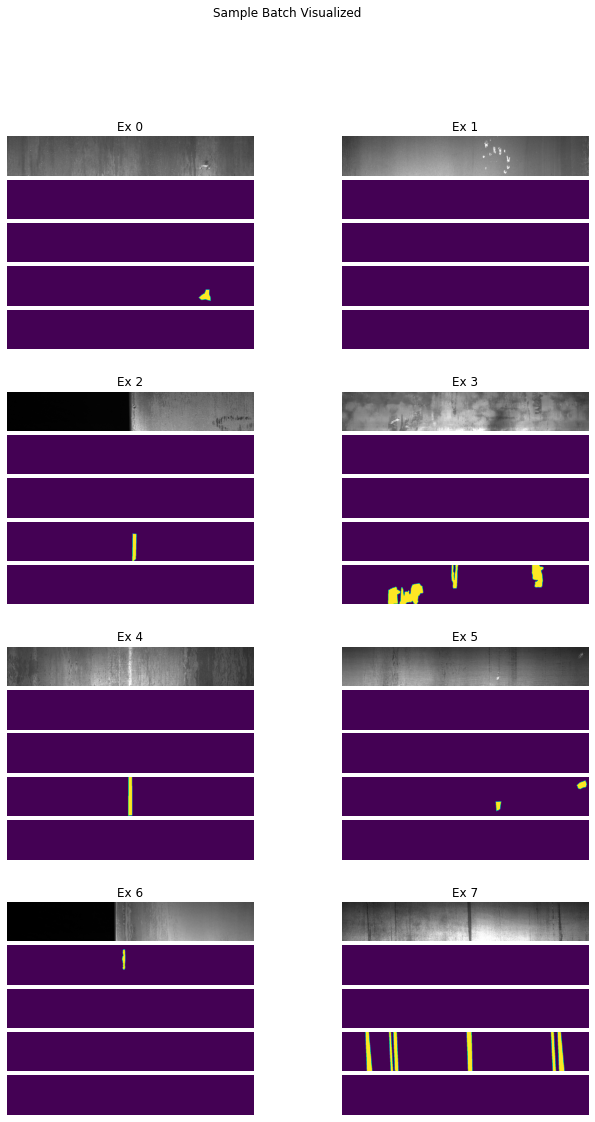

In [12]:
plot_sample_batch(sample_inline)

## Benchmarking (TO DO)

## `tf.data` pipeline

Benchmark the following scenarios:

0. Impact of cache, batch, prefetch?
1. Masks are RLE encoded in csv file (i.e. tf.data pipeline has to transform into Tensors)
2. Masks and images are pre-saved as Tensors (i.e. all image masks are converted to tf.records prior)
3. Masks/images are loaded using `keras.utils.Sequence` (ex. https://keras.io/examples/vision/oxford_pets_image_segmentation/)
4. ImageDataGenerator in keras...
5. Using np_func / py_func for RLE decoding vs. raw TensorFlow functions

In [16]:
def benchmark_dataloading(dataset, n_epochs):
    start = time.time()
    for epoch in range(n_epochs):
        for i, sample in enumerate(dataset):
            time.sleep(0.01)  # imitate train step
            pass
    end = time.time()
    print("Execution time:", end - start)

In [17]:
# batch only
benchmark_dataloading(train_dataset, 1)

Execution time: 310.7924337387085


In [8]:
# batch only
benchmark_dataloading(train_dataset, 5)

Execution time: 11.809537172317505


In [13]:
# cache and batch
benchmark_dataloading(train_dataset, 5)

Execution time: 3.296800374984741


In [16]:
# batch, cache, prefetch
benchmark_dataloading(train_dataset, 5)

Execution time: 3.540153741836548
